## 다변량 시계열 데이터 (Multivariate Time Series Data) with VAR
- https://dining-developer.tistory.com/32 를 참고하였습니다.
- https://alpaca-gt.tistory.com/311 에 정리하였습니다.

#### 1. Library & data load

In [7]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller

In [8]:
data = sm.datasets.macrodata.load_pandas().data     # 실질GDP 샘플
data.head()

,year,quarter,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint
0,1959.0,1.0,2710.349,1707.4,286.898,470.045,1886.9,28.98,139.7,2.82,5.8,177.146,0.00,0.00
1,1959.0,2.0,2778.801,1733.7,310.859,481.301,1919.7,29.15,141.7,3.08,5.1,177.830,2.34,0.74
2,1959.0,3.0,2775.488,1751.8,289.226,491.260,1916.4,29.35,140.5,3.82,5.3,178.657,2.74,1.09
3,1959.0,4.0,2785.204,1753.7,299.356,484.052,1931.3,29.37,140.0,4.33,5.6,179.386,0.27,4.06
4,1960.0,1.0,2847.699,1770.5,331.722,462.199,1955.5,29.54,139.6,3.50,5.2,180.007,2.31,1.19


- year, realgdp, realdpi 세가지만 사용

In [9]:
mydata = data[["realgdp", 'realdpi']]
mydata.index = data["year"]
mydata.head()

,realgdp,realdpi
year,,
1959.0,2710.349,1886.9
1959.0,2778.801,1919.7
1959.0,2775.488,1916.4
1959.0,2785.204,1931.3
1960.0,2847.699,1955.5


- Stationary time series
     + 데이터가 정상성을 가진다는 의미는 데이터의 평균과 분산이 안정되어 있어 분석하기 쉬움
     + VAR을 적용시켜보기 전에 두 시계열 변수가 모두 stationay 상태이어야 함

<AxesSubplot:xlabel='year'>

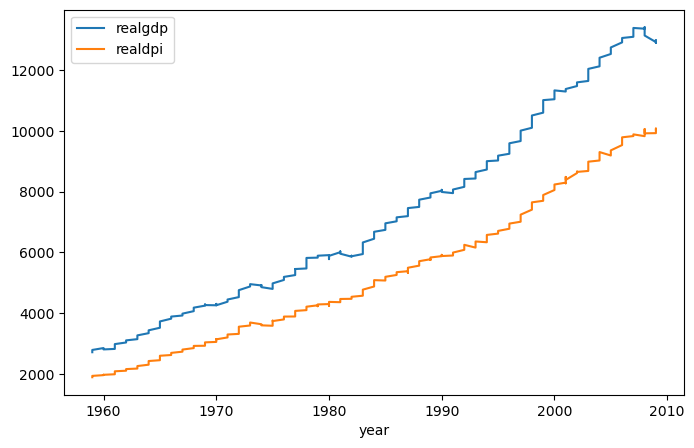

In [10]:
mydata.plot(figsize = (8,5))

#### 2. AIC 기준을 사용

- 데이터의 stationarity를 찾기 위해 ADF(Advanced Dickey-Fuller test)와 같은 통계적 테스트를 수행

In [11]:
adfuller_test = adfuller(mydata['realgdp'], autolag= "AIC")

print("ADF test statistic: {}".format(adfuller_test[0]))
print("p-value: {}".format(adfuller_test[1]))

ADF test statistic: 1.7504627967647106
p-value: 0.9982455372335032


In [12]:
adfuller_test = adfuller(mydata['realdpi'], autolag= "AIC")

print("ADF test statistic: {}".format(adfuller_test[0]))
print("p-value: {}".format(adfuller_test[1]))

ADF test statistic: 2.9860253519546878
p-value: 1.0


#### 3. differencing (차분)

In [13]:
mydata_diff = mydata.diff().dropna()

In [14]:
adfuller_test = adfuller(mydata_diff['realgdp'], autolag= "AIC")
print("ADF test statistic: {}".format(adfuller_test[0]))
print("p-value: {}".format(adfuller_test[1]))

ADF test statistic: -6.305695561658104
p-value: 3.327882187668259e-08


In [16]:
adfuller_test = adfuller(mydata_diff['realdpi'], autolag= "AIC")
print("ADF test statistic: {}".format(adfuller_test[0]))
print("p-value: {}".format(adfuller_test[1]))

ADF test statistic: -8.86489334067301
p-value: 1.4493606159107938e-14


#### 4. 모델링

- 마지막 10일은 test 나머지는 train

In [17]:
train = mydata_diff.iloc[:-10,:]
test = mydata_diff.iloc[-10:,:]

In [18]:
train

,realgdp,realdpi
year,,
1959.0,68.452,32.8
1959.0,-3.313,-3.3
1959.0,9.716,14.9
1960.0,62.495,24.2
1960.0,-13.309,10.6
...,...,...
2006.0,167.239,175.1
2006.0,46.524,83.5
2006.0,3.454,45.2


- VAR모델의 최적 순서
    - 최적의 모델을 찾기 위한 기준 AIC(Akaike's Information Criterion)를 모델 선택 기준
    - 최상의 AIC점수를 바탕으로 VAR의 순서(p)를 선택
    - AIC는 일반적으로 모델이 너무 복잡하다는 이유로 불이익을 주곤 하는데 복잡한 모델은 일부 다른 모델 선택 기준에서 약간 더 나은 성능을 보여 줄 수 있음
    - 순서(p) 검색 시 변곡점이 예상되는데, 이는 일정 순서가 될 때까지 순서 p가 커지면 AIC점수가 감소하고, 이후 점수가 높아지기 시작한다

- grid-search를 수행해서 최적의 p
    - fit으로 VAR 모델을 학습
    - 1부터 10까지 적합한 순서에 대한 AIC 점수를 찾기 위해 반복문을 통해 grid-search

In [19]:
forecasting_model = VAR(train)
results_aic = []

for p in range(1,10):
  results = forecasting_model.fit(p)
  results_aic.append(results.aic)

/home/ubuntu/anaconda3/envs/info/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


- 결과 그래프에서 가장 낮은 AIC점수는 2이고, 그 이후 p가 커짐에 따라 증가 추세
    - VAR모델의 최적 순서는 2

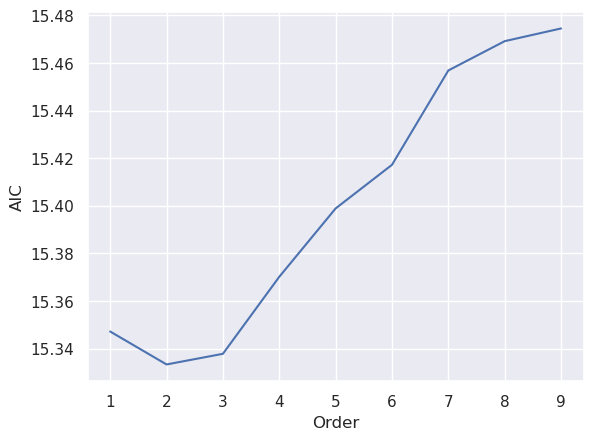

In [20]:
sns.set()
plt.plot(list(np.arange(1,10,1)), results_aic)
plt.xlabel("Order")
plt.ylabel("AIC")
plt.show()

- 모형에 순서 2로 fit 시키고 요약 결과

In [21]:
results = forecasting_model.fit(2)
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 28, Sep, 2022
Time:                     10:10:12
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    15.5043
Nobs:                     190.000    HQIC:                   15.4026
Log likelihood:          -1985.87    FPE:                4.56270e+06
AIC:                      15.3334    Det(Omega_mle):     4.33171e+06
--------------------------------------------------------------------
Results for equation realgdp
                coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------
const             23.807343         6.111430            3.896           0.000
L1.realgdp         0.176227         0.078131            2.256           0.024
L1.realdpi         0.213713         0.085309            2.505         

#### 5. 예측하기

- 학습된 모델에 2일 동안의 훈련을 넣어 향후 10일 동안의 테스트 데이터를 예측

In [22]:
laaged_values = train.values[-2:]
forecast = pd.DataFrame(results.forecast(y= laaged_values, steps=10), index = test.index, columns= ['realgdp_1d', 'realdpi_1d'])
forecast

,realgdp_1d,realdpi_1d
year,,
2007.0,61.872982,47.739232
2007.0,53.948996,41.742951
2007.0,56.171082,42.552316
2008.0,54.953081,42.023999
2008.0,55.109616,42.001007
2008.0,54.865410,41.937065
2008.0,54.841362,41.893996
2009.0,54.775171,41.878378
2009.0,54.754309,41.859837


- 언급한 예측이 차분(diffencing)에 대한 모델에 대한 것
- 차분을 더하여 우리가 예측해야 할 값으로 만들기
    - 왼쪽(_1d)은 차분에 대한 예측값
    - 오른쪽 (_forcasted)은 원래 시리즈에 대한 예측값

In [23]:
forecast["realgdp_forecasted"] = mydata["realgdp"].iloc[-10-1] + forecast['realgdp_1d'].cumsum()
forecast["realdpi_forecasted"] = mydata["realdpi"].iloc[-10-1] + forecast['realdpi_1d'].cumsum() 
forecast

,realgdp_1d,realdpi_1d,realgdp_forecasted,realdpi_forecasted
year,,,,
2007.0,61.872982,47.739232,13161.773982,9877.939232
2007.0,53.948996,41.742951,13215.722978,9919.682183
2007.0,56.171082,42.552316,13271.894060,9962.234500
2008.0,54.953081,42.023999,13326.847141,10004.258499
2008.0,55.109616,42.001007,13381.956757,10046.259506
2008.0,54.865410,41.937065,13436.822166,10088.196571
2008.0,54.841362,41.893996,13491.663528,10130.090566
2009.0,54.775171,41.878378,13546.438699,10171.968945
2009.0,54.754309,41.859837,13601.193008,10213.828781


- 실제 test 셋과 합쳐서 시각화
    - realdpi와 realdpi_forecasted는 비슷한 패턴
    - realgdp와 realgdp_forecasted는 절반 정도는 비슷하다가 다른 패턴

/tmp/ipykernel_3612/3591658555.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["realgdp_forecasted"] = forecast["realgdp_forecasted"]
/tmp/ipykernel_3612/3591658555.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["realdpi_forecasted"] = forecast["realdpi_forecasted"]


<AxesSubplot:xlabel='year'>

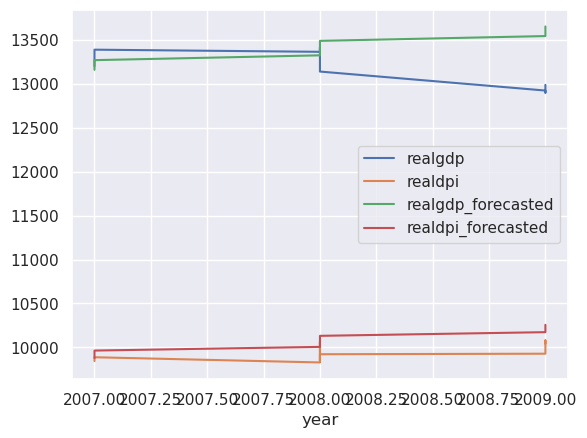

In [24]:
test = mydata.iloc[-10:,:]
test["realgdp_forecasted"] = forecast["realgdp_forecasted"]
test["realdpi_forecasted"] = forecast["realdpi_forecasted"]
test.plot()